In [1]:
import numpy as np
import phoebe
from phoebe import u, c

import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils

logger = phoebe.logger(clevel='WARNING')

In [2]:
# helper variables
gaiaDatasets = ['lcGaiaG', 'lcGaiaRP', 'lcGaiaBP']
iturbideDatasets = ['lcIturbideAviles', 'lcIturbideFull']
ztfDatasets = ['lcZtfG', 'lcZtfR']
trimmedZtfDatasets = ['lcZtfGTrimmed', 'lcZtfRTrimmed']
allDatasets = gaiaDatasets + iturbideDatasets + ztfDatasets
plotAllDatasetsGroups = [['lcIturbideAviles'], ['lcIturbideFull'], gaiaDatasets, ztfDatasets]

In [3]:
b = gen_utils.loadBundle(bundleName='after-dc', parentFolder='../optimizers')

In [8]:
b.add_dataset('lc', dataset='lcGaiaG', overwrite=True, passband='Gaia:G', 
			  times=b.get_value(qualifier='times', dataset='lc_gaia_g_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_g_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_g_raw', context='dataset'),
			  pblum_mode='component-coupled', pblum=b.get_value(qualifier='pblum', dataset='lc_gaia_g_raw'))
b.add_dataset('lc', dataset='lcGaiaRP', overwrite=True, passband='Gaia:RP',
			  times=b.get_value(qualifier='times', dataset='lc_gaia_rp_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_rp_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_rp_raw', context='dataset'),
			  pblum_mode='dataset-coupled', pblum_dataset='lcGaiaG')
b.add_dataset('lc', dataset='lcGaiaBP', overwrite=True, passband='Gaia:BP',
			  times=b.get_value(qualifier='times', dataset='lc_gaia_bp_raw', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_gaia_bp_raw', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_gaia_bp_raw', context='dataset'),
			  pblum_mode='dataset-coupled', pblum_dataset='lcGaiaG')

b.add_dataset('lc', dataset='lcIturbideFull', overwrite=True, pblum_mode='dataset-scaled',
			  times=b.get_value(qualifier='times', dataset='lc_iturbide_norm', context='dataset'),
			  fluxes=b.get_value(qualifier='fluxes', dataset='lc_iturbide_norm', context='dataset'),
			  sigmas=b.get_value(qualifier='sigmas', dataset='lc_iturbide_norm', context='dataset'))

<ParameterSet: 47 parameters | contexts: compute, constraint, dataset, figure>

In [13]:
b.flip_constraint(qualifier='ebv', solve_for='Av')

<ConstraintParameter: {Av@system} = {Rv@system} * {ebv@system} (solar units) => 0.0>

In [14]:
b.set_value(qualifier='ebv', value=0.1526) # IRSA SFD (1998) max

In [15]:
gen_utils.abilitateDatasets(b, enableDatasets=trimmedZtfDatasets + gaiaDatasets, includeMesh=False)
b.run_compute(model='before_data_removal', overwrite=True)

Mon, 03 Jun 2024 16:19 BUNDLE       WARNING updating installed Gaia:G passband (with matching online timestamp) to include content=['ck2004:ext']
Mon, 03 Jun 2024 16:19 PASSBANDS    WARNING passband 'Gaia:G' already exists with local=True... removing
Mon, 03 Jun 2024 16:19 PASSBANDS    WARNING deleting file: /home/ramon/.phoebe/atmospheres/tables/passbands/gaia_g.fits
Mon, 03 Jun 2024 16:19 BUNDLE       WARNING updating installed Gaia:RP passband (with matching online timestamp) to include content=['ck2004:ext']
Mon, 03 Jun 2024 16:19 PASSBANDS    WARNING passband 'Gaia:RP' already exists with local=True... removing
Mon, 03 Jun 2024 16:19 PASSBANDS    WARNING deleting file: /home/ramon/.phoebe/atmospheres/tables/passbands/gaia_rp.fits
Mon, 03 Jun 2024 16:20 BUNDLE       WARNING updating installed Gaia:BP passband (with matching online timestamp) to include content=['ck2004:ext']
Mon, 03 Jun 2024 16:20 PASSBANDS    WARNING passband 'Gaia:BP' already exists with local=True... removing
Mo

ValueError: failed to pass checks
Run Checks Report: FAIL
ERROR: 'ZTF:g' passband (passband@lcZtfG@lc@dataset) does not support ck2004:ext (atm@primary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'ZTF:g' passband (passband@lcZtfG@lc@dataset) does not support ck2004:ext (atm@secondary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'ZTF:r' passband (passband@lcZtfR@lc@dataset) does not support ck2004:ext (atm@primary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'ZTF:r' passband (passband@lcZtfR@lc@dataset) does not support ck2004:ext (atm@secondary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'Johnson:V' passband (passband@lc_iturbide_norm@lc@dataset) does not support ck2004:ext (atm@primary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'Johnson:V' passband (passband@lc_iturbide_norm@lc@dataset) does not support ck2004:ext (atm@secondary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'ZTF:g' passband (passband@lcZtfGTrimmed@lc@dataset) does not support ck2004:ext (atm@primary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'ZTF:g' passband (passband@lcZtfGTrimmed@lc@dataset) does not support ck2004:ext (atm@secondary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'ZTF:r' passband (passband@lcZtfRTrimmed@lc@dataset) does not support ck2004:ext (atm@primary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'ZTF:r' passband (passband@lcZtfRTrimmed@lc@dataset) does not support ck2004:ext (atm@secondary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'Johnson:V' passband (passband@lcIturbideFull@lc@dataset) does not support ck2004:ext (atm@primary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)
ERROR: 'Johnson:V' passband (passband@lcIturbideFull@lc@dataset) does not support ck2004:ext (atm@secondary@phoebe01@phoebe@compute). (2 affected parameters, affecting run_compute)

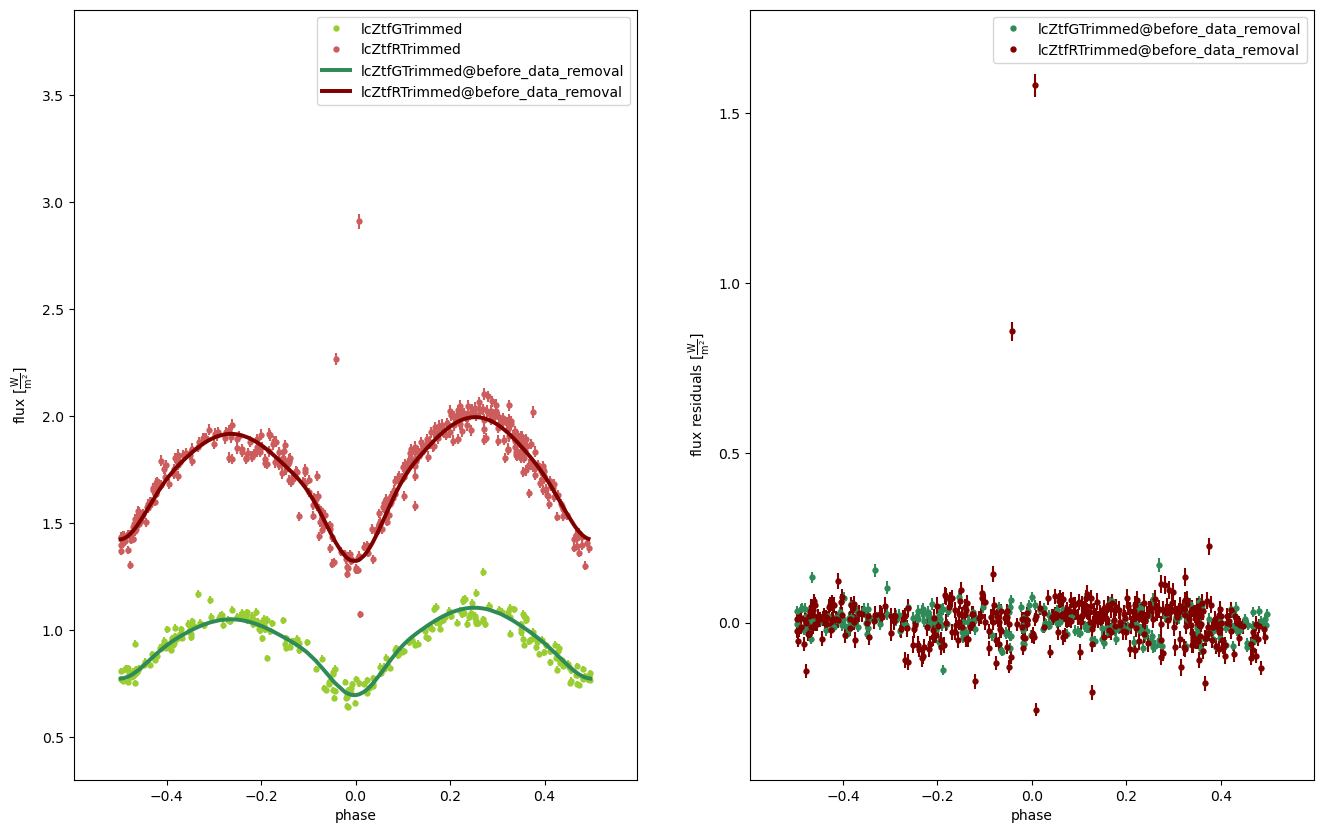

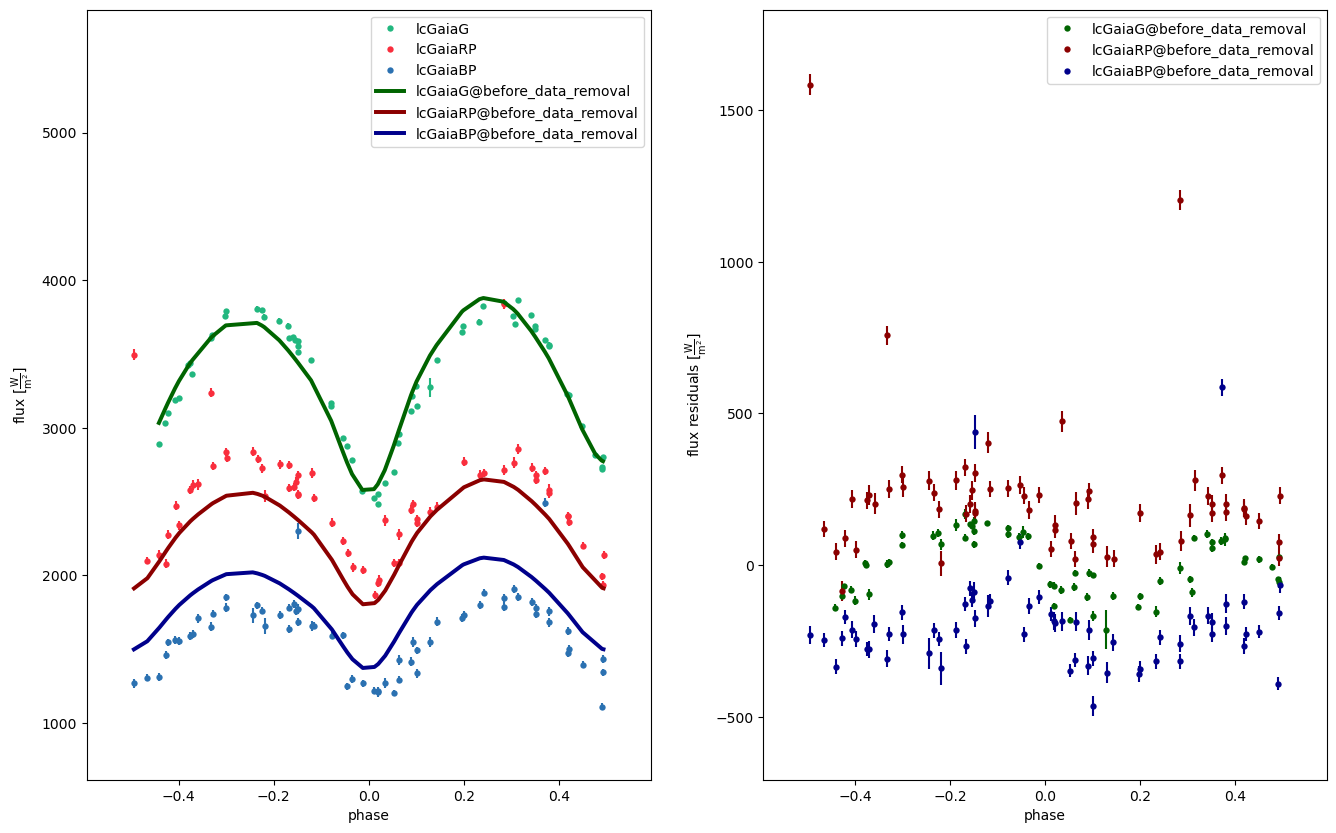

{'lcZtfGTrimmed-lcZtfRTrimmed': <Figure size 1600x1000 with 2 Axes>,
 'lcGaiaG-lcGaiaRP-lcGaiaBP': <Figure size 1600x1000 with 2 Axes>}

In [10]:
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[trimmedZtfDatasets, gaiaDatasets], model='before_data_removal')

In [17]:
def get_model_residuals(dataset: str, model: str) -> np.ndarray:
	return b.get_value(qualifier='fluxes', dataset=dataset, context='dataset') - b.get_value(qualifier='fluxes', dataset=dataset, model=model)

def plot_residuals(dataset: str, model: str) -> None:
	colors = {
		'lcZtfRTrimmed': 'darkred',
		'lcZtfGTrimmed': 'darkgreen'
	}

	residuals = get_model_residuals(dataset, model)
	
	_, axs = plt.subplots(1, 2, figsize=(22, 10))
	axs[0].hist(residuals, bins=300, color=colors[dataset], label=dataset)
	
	axs[1].plot(b.to_phase(b.get_value(qualifier='times', dataset=dataset, model=model)), residuals, color=colors[dataset], label=dataset, marker='.', linestyle='none')
	# axs[1].plot(b.get_value(qualifier='times', dataset=dataset, model='after_dc_model'), afterDcResiduals, color=colors[dataset], label=dataset, marker='.', linestyle='none')
	axs[1].legend()
	plt.show()

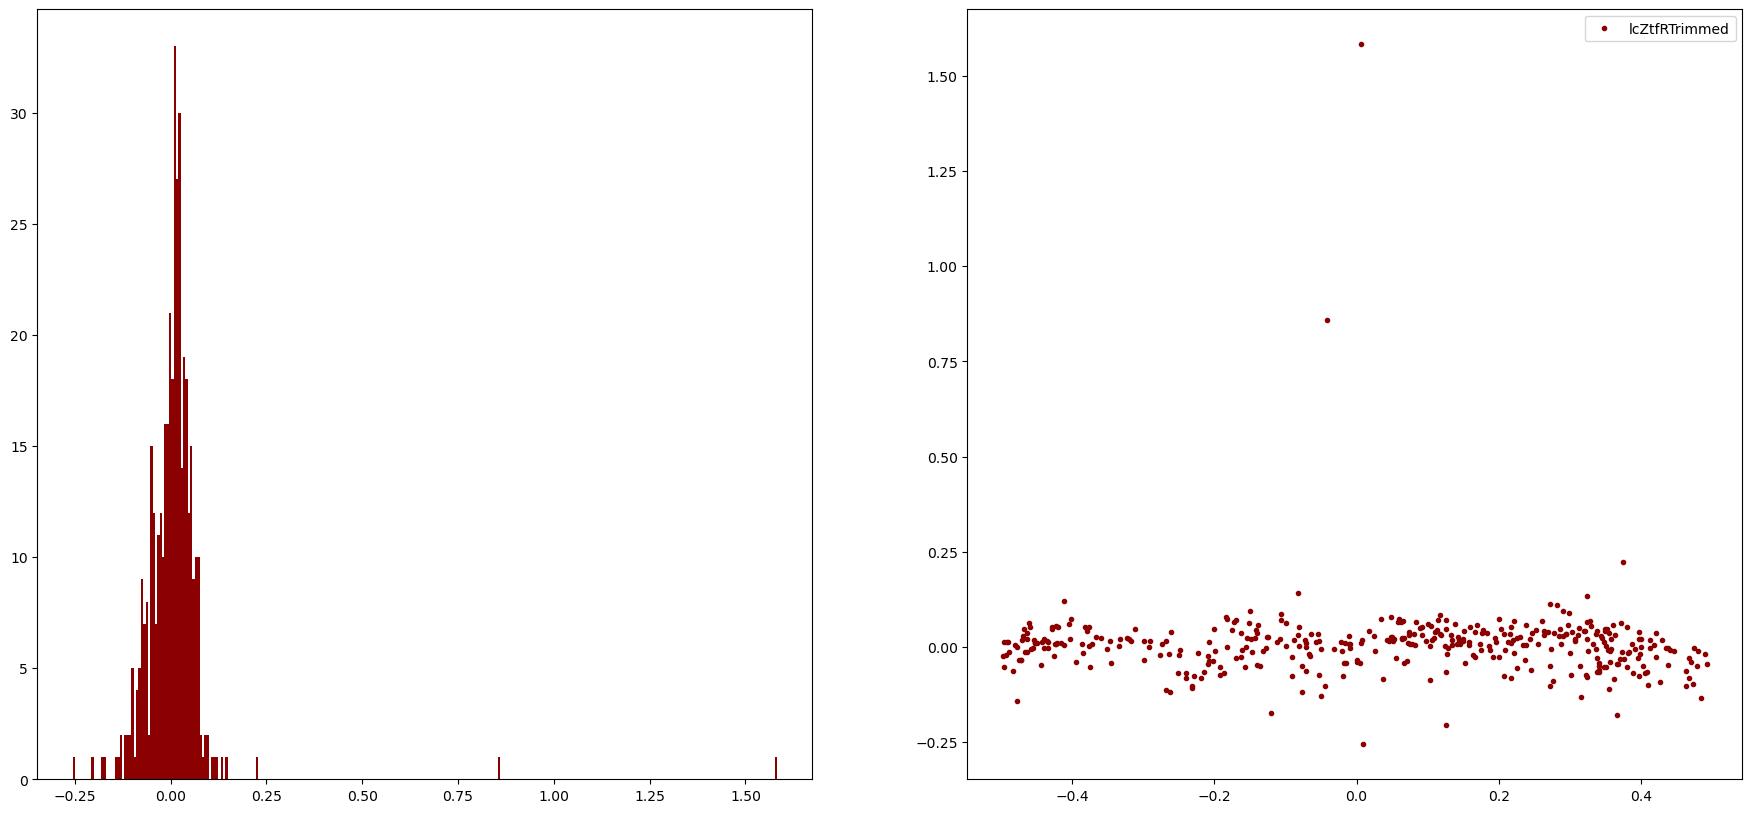

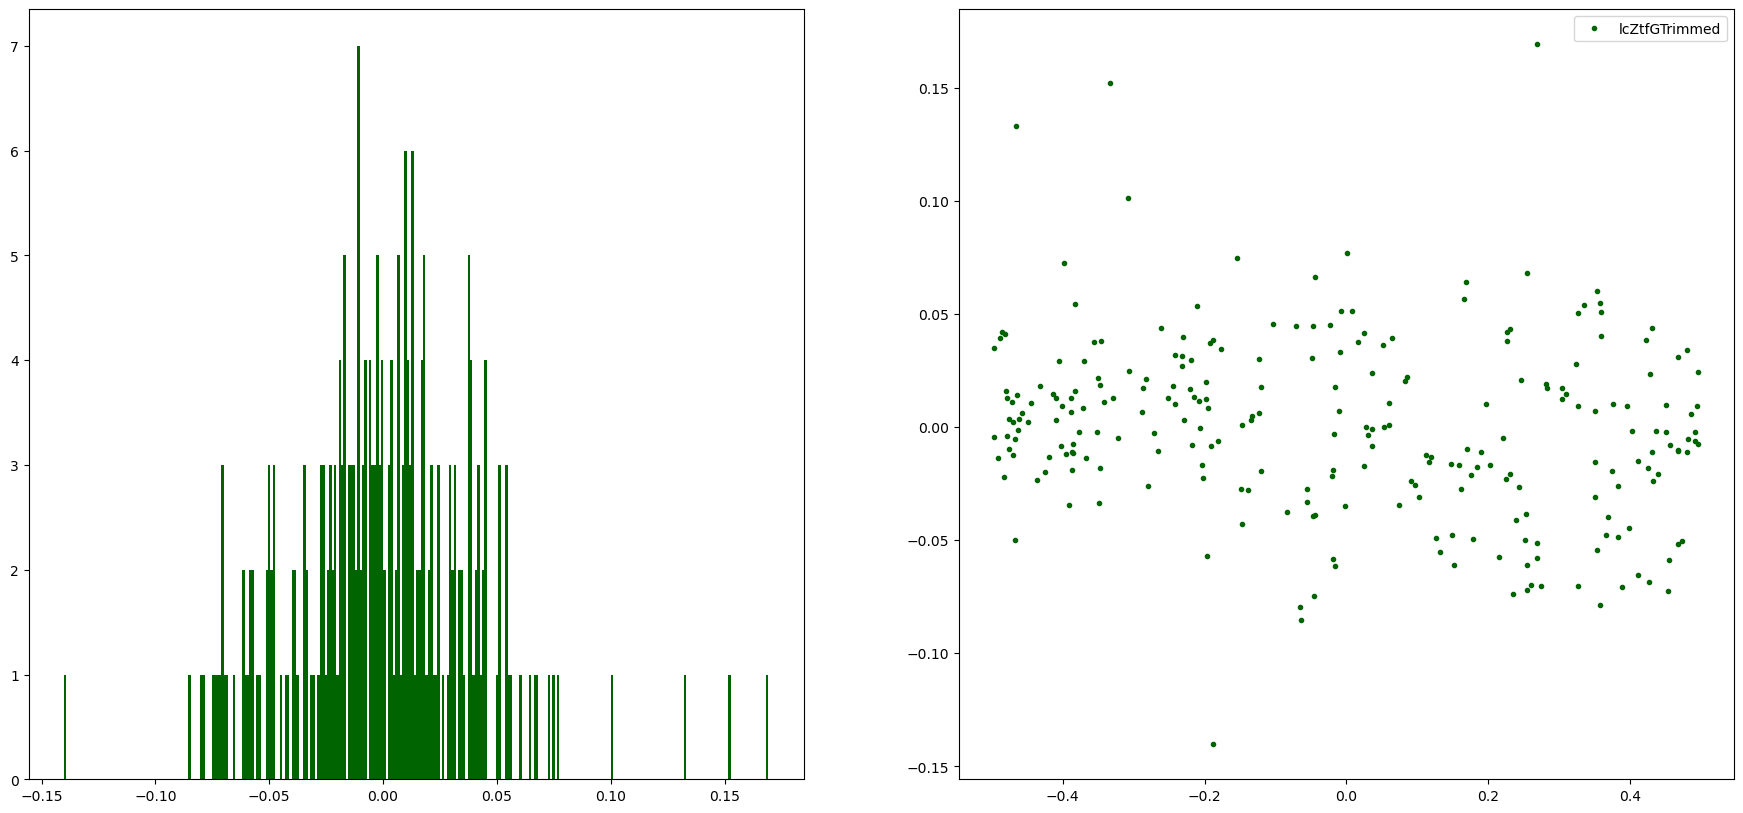

In [8]:
r_residuals = get_model_residuals('lcZtfRTrimmed', 'before_data_removal')
g_residuals = get_model_residuals('lcZtfGTrimmed', 'before_data_removal')

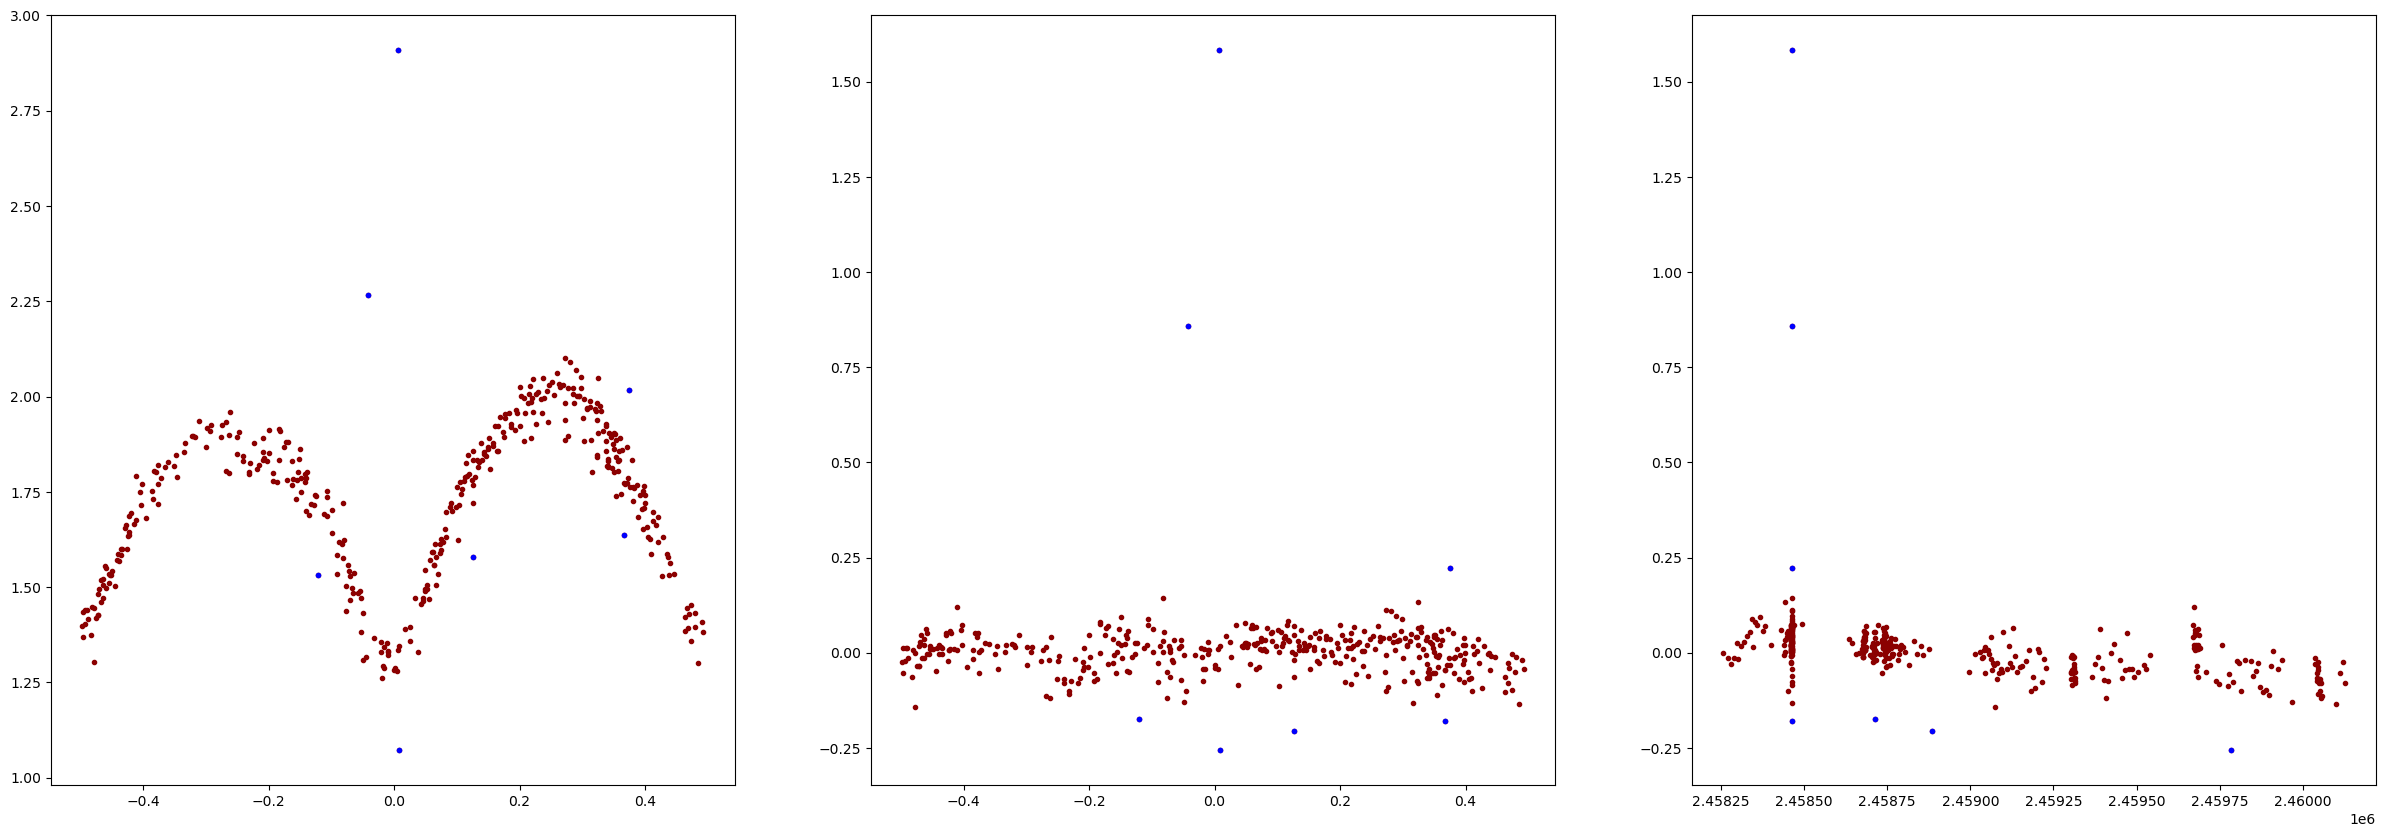

In [9]:
r_std = np.std(r_residuals)
r_mean = np.mean(r_residuals)
r_meanDistance = np.abs(r_residuals - r_mean)
r_badMask = np.ma.masked_where(r_meanDistance > 1.5*r_std, r_meanDistance).mask

r_times = b.get_value(qualifier='times', dataset='lcZtfRTrimmed', model='before_data_removal')
r_phase = b.to_phase(r_times)
r_dataFlux = b.get_value(qualifier='fluxes', dataset='lcZtfRTrimmed', context='dataset')
r_dataSigmas = b.get_value(qualifier='sigmas', dataset='lcZtfRTrimmed', context='dataset')

_, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].plot(r_phase, r_dataFlux, color='darkred', marker='.', linestyle='none')
axs[0].plot(r_phase[r_badMask], r_dataFlux[r_badMask], color='blue', marker='.', linestyle='none')

axs[1].plot(r_phase, r_residuals, color='darkred', marker='.', linestyle='none')
axs[1].plot(r_phase[r_badMask], r_residuals[r_badMask], color='blue', marker='.', linestyle='none')

axs[2].plot(r_times, r_residuals, color='darkred', marker='.', linestyle='none')
axs[2].plot(r_times[r_badMask], r_residuals[r_badMask], color='blue', marker='.', linestyle='none')

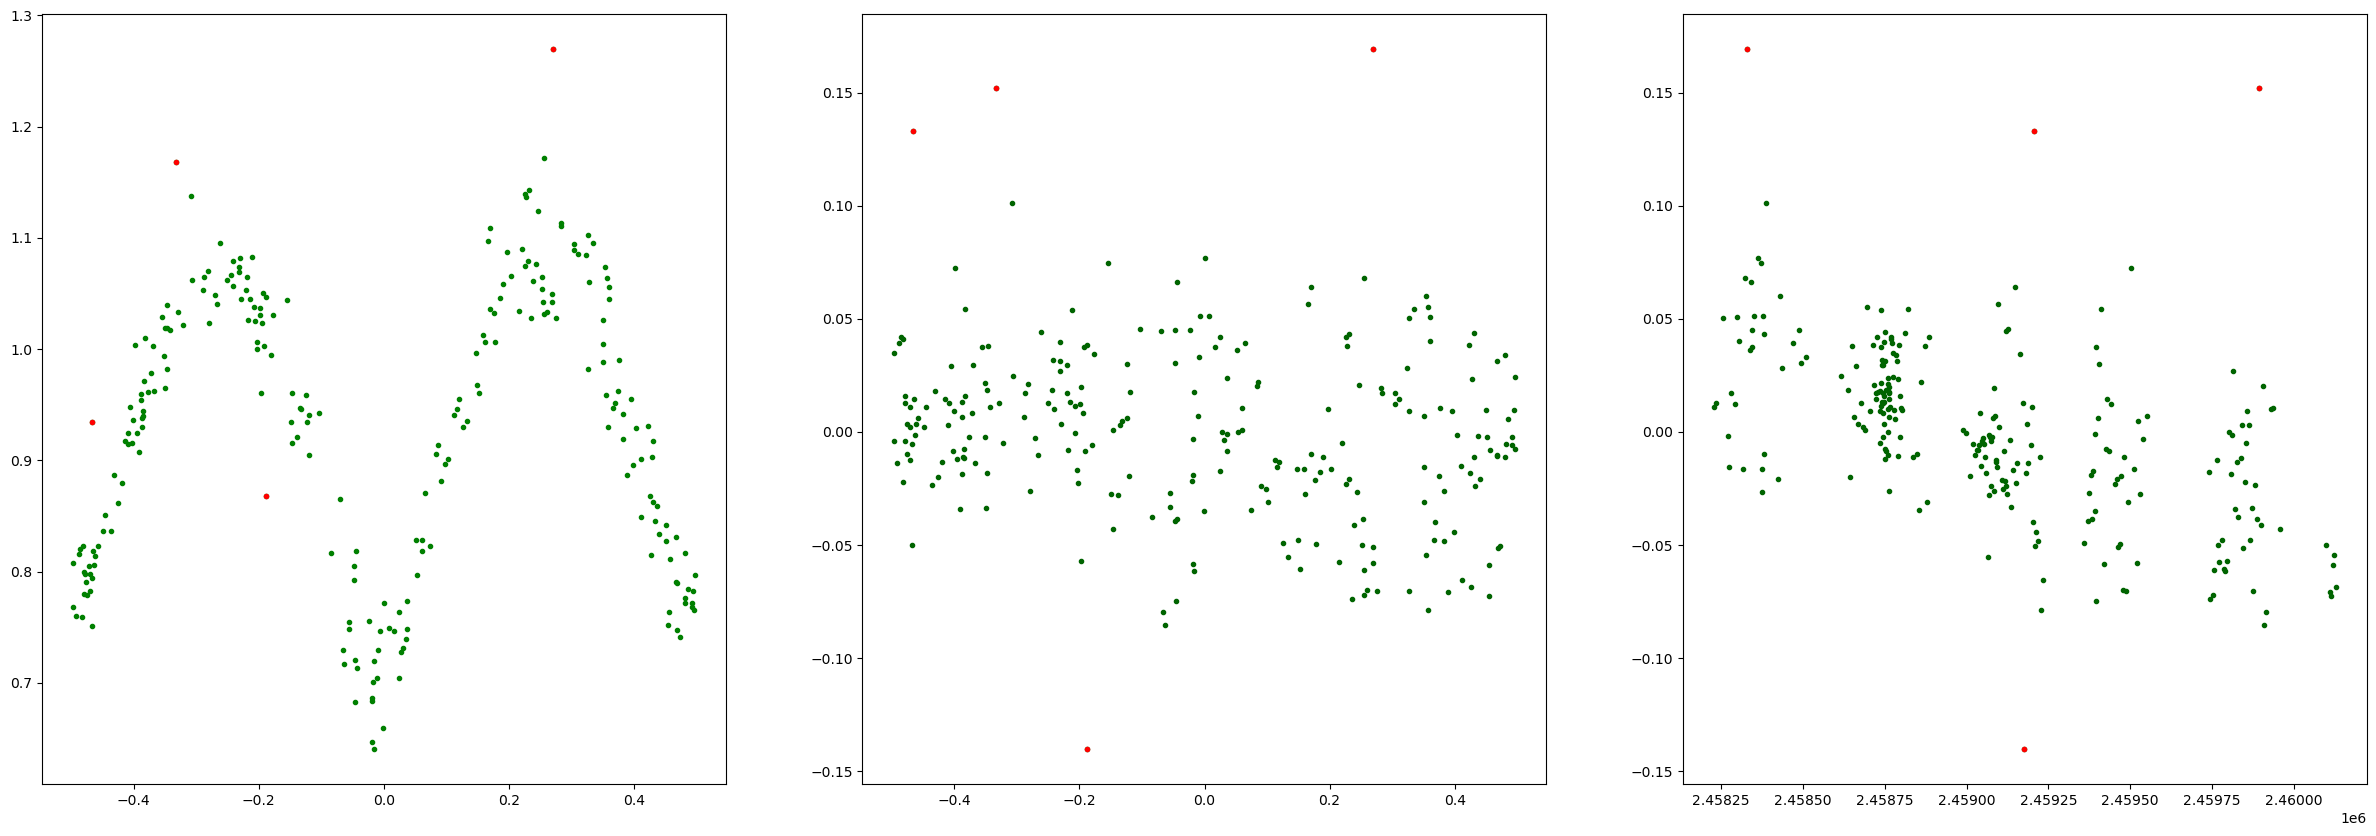

In [10]:
g_std = np.std(g_residuals)
g_mean = np.mean(g_residuals)
g_meanDistance = np.abs(g_residuals - g_mean)
g_badMask = np.ma.masked_where(g_meanDistance > 3*g_std, g_meanDistance).mask

g_times = b.get_value(qualifier='times', dataset='lcZtfGTrimmed', model='after_dc_model')
g_phase = b.to_phase(g_times)
g_dataFlux = b.get_value(qualifier='fluxes', dataset='lcZtfGTrimmed', context='dataset')
g_dataSigmas = b.get_value(qualifier='sigmas', dataset='lcZtfGTrimmed', context='dataset')

_, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].plot(g_phase, g_dataFlux, color='green', marker='.', linestyle='none')
axs[0].plot(g_phase[g_badMask], g_dataFlux[g_badMask], color='red', marker='.', linestyle='none')

axs[1].plot(g_phase, g_residuals, color='darkgreen', marker='.', linestyle='none')
axs[1].plot(g_phase[g_badMask], g_residuals[g_badMask], color='red', marker='.', linestyle='none')

axs[2].plot(g_times, g_residuals, color='darkgreen', marker='.', linestyle='none')
axs[2].plot(g_times[g_badMask], g_residuals[g_badMask], color='red', marker='.', linestyle='none')

100%|██████████| 645/645 [01:25<00:00,  7.56it/s]


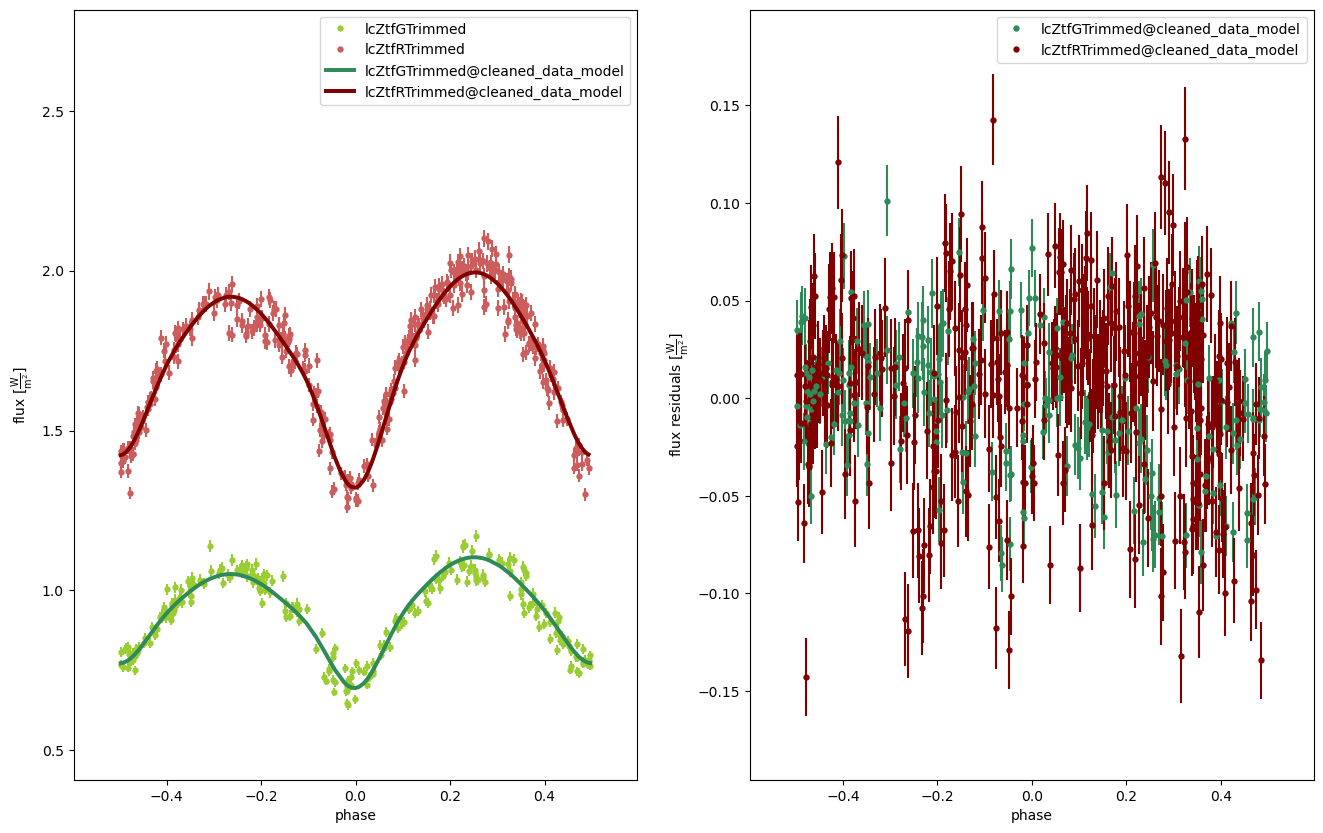

{'lcZtfGTrimmed-lcZtfRTrimmed': <Figure size 1600x1000 with 2 Axes>}

In [11]:
b.add_dataset('lc', dataset='lcZtfGTrimmed', times=g_times[~g_badMask], fluxes=g_dataFlux[~g_badMask], sigmas=g_dataSigmas[~g_badMask], pblum_mode='component-coupled', pblum=b.get_quantity(qualifier='pblum', dataset='lcZtfGTrimmed', context='dataset'), overwrite=True, passband='ZTF:g')
b.add_dataset('lc', dataset='lcZtfRTrimmed', times=r_times[~r_badMask], fluxes=r_dataFlux[~r_badMask], sigmas=r_dataSigmas[~r_badMask], pblum_mode='dataset-coupled', pblum_dataset='lcZtfGTrimmed', overwrite=True, passband='ZTF:r')

gen_utils.abilitateDatasets(b, trimmedZtfDatasets, False)
b.run_compute(model='cleaned_data_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[trimmedZtfDatasets], model='cleaned_data_model')

In [114]:
gen_utils.saveBundle(b, "sigma_cleaned_ztf_data")

Thu, 30 May 2024 23:42 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/sigma_cleaned_ztf_data.json.gz'